In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

import astropy.units as u
from astroquery.hips2fits import hips2fits
from astropy.coordinates import Longitude, Latitude, Angle

import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from utils.sersic_functions import sersic_profile

In [2]:
df = pd.read_csv("../data/SERSIC/delight_sersic.csv", index_col='oid', dtype={'objID': 'Int64'})

In [3]:
df.shape

(16795, 117)

In [4]:
ser_columns = [
    "objID", "host_ra", "host_dec", "hostsize",
    "rSerRadius", "rSerAb", "rSerPhi", "rSerChisq", "rSerRa", "rSerDec",
]

In [5]:
df_sersic = (
    df.dropna(subset=ser_columns)                        # Eliminamos ejemplos con nan
      .loc[~(df[ser_columns] == -999).any(axis=1)]       # Eliminamos ejemplos con -999
      [ser_columns]
      .drop_duplicates(subset="objID")                   # Eliminamos galaxias duplicadas
)

In [6]:
df_sersic

,objID,host_ra,host_dec,hostsize,rSerRadius,rSerAb,rSerPhi,rSerChisq,rSerRa,rSerDec
oid,,,,,,,,,,
ZTF19acaqqxo,160611556472747538,155.647290,43.847310,66.722168,9.03469,0.530315,85.152397,3.442620,155.647339,43.847298
ZTF19acbpxwt,186802409857776654,240.985580,65.671610,11.103163,2.78418,0.588130,59.962700,1.619010,240.985764,65.671585
ZTF19acbpzir,204222826241433588,282.625080,80.185580,15.026858,3.64761,0.785985,50.942001,1.488890,282.625214,80.185600
ZTF19acbwiry,143772452174004405,245.217375,29.811500,6.210382,1.66751,0.724595,40.693100,1.258510,245.217407,29.811502
ZTF19accdaqi,142401513500480472,151.350090,28.666630,17.474194,3.81206,0.681890,-48.438400,2.436470,151.350082,28.666599
...,...,...,...,...,...,...,...,...,...,...
ZTF18aceckot,118370622996699212,62.299708,8.648750,46.701057,9.05507,0.724950,-32.208900,210.123993,62.299549,8.649583
ZTF19aaydpzi,77202105141399104,210.514205,-25.659288,52.289154,6.45473,0.515725,49.031799,38.676701,210.514084,-25.659275
ZTF19acapeun,145180449975404946,44.997188,30.986714,33.356407,6.52419,0.550212,52.672600,3.608650,44.997478,30.987041


### EDA

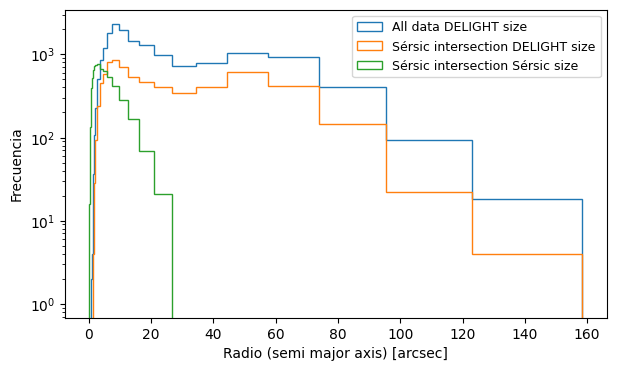

In [7]:
bins = np.logspace(-1,2.2,30)

plt.figure(figsize=(7,4))
plt.hist(df['hostsize'], bins=bins, histtype="step", label="All data DELIGHT size")
plt.hist(df_sersic["hostsize"], bins=bins, histtype="step", label ="Sérsic intersection DELIGHT size")
plt.hist(df_sersic["rSerRadius"], bins=bins, histtype="step", label = "Sérsic intersection Sérsic size")

plt.legend(fontsize=9)
plt.yscale("log")
#plt.xscale("log")

plt.ylabel("Frecuencia")
plt.xlabel("Radio (semi major axis) [arcsec]")
plt.show()

299.97480010986357
32.59961986541748
46.83246297066452
42.731567230019174


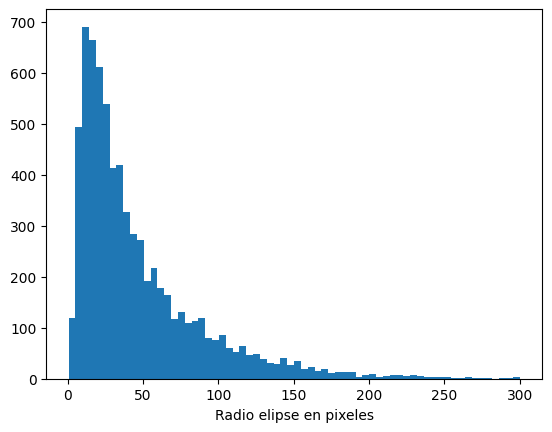

In [8]:
# Radio de las elipses de Sersic (3 veces el radio) en pixeles
# En este caso seleccionamos 210 pixeles de radio

print(df_sersic["rSerRadius"].max()*3/0.25)
print(df_sersic["rSerRadius"].median()*3/0.25)
print(df_sersic["rSerRadius"].mean()*3/0.25)
print(df_sersic["rSerRadius"].std()*3/0.25)

plt.hist(df_sersic["rSerRadius"]*3/0.25, bins="auto")
plt.xlabel("Radio elipse en pixeles")
plt.show()

### Funciones

In [9]:
def get_sdss_img(df, id, fov, size):
    
    ra,dec = np.float64(df.iloc[id][["host_ra","host_dec"]].values)

    r = hips2fits.query(
        hips="CDS/P/PanSTARRS/DR1/r",
        width=size,
        height=size,
        ra=Longitude(ra * u.deg),
        dec=Latitude(dec * u.deg),
        fov=Angle(fov  * u.deg),
        projection="TAN",
        get_query_payload=False,
        format='fits',
        )

    r = r[0].data.byteswap().newbyteorder()
    r = np.nan_to_num(r, 0)

    # Las imagenes de DELIGHT estan con estas transformaciones
    r = np.rot90(r, k=1)
    r = np.flipud(r)
    return r

In [ ]:
def plot_galaxy_and_sersic(df, idx, Ie=1.0, n=4, scale_factor=3):

    row = df.iloc[idx]
    image_data = get_sdss_img(df, idx, fov=240*0.25/3600, size=240) #Imagen de 240x240 con resolucion 0.25 arcsec/pix

    # Coordenadas del centro
    x_center, y_center = image_data.shape[0]//2 -1 , image_data.shape[1]//2 -1

    # Parámetros de Sérsic
    Re_arcsec = row["rSerRadius"]
    b_over_a = row["rSerAb"]
    theta_sersic = row["rSerPhi"]  # Usar el ángulo original
    pixel_scale = 0.25
    Re_pix = Re_arcsec / pixel_scale
    A_pix = Re_pix
    B_pix = A_pix * b_over_a

    # Generar perfil de Sérsic
    sersic_img = sersic_profile(
        image_shape=image_data.shape,
        x_center=x_center, y_center=y_center,
        Re_arcsec=Re_arcsec,
        b_over_a=b_over_a,
        theta_deg=theta_sersic,  
        pixel_scale=pixel_scale,
        Ie=Ie,
        n=n
    )

    # vemos las posiciones que tomo la supernova en 1000 iteraciones
    pares = []
    for _ in range(1000):

        pesos = sersic_img.ravel()
        pesos = pesos / pesos.sum()

        indice_aleatorio = np.random.choice(len(pesos), p=pesos)

        y_supernova, x_supernova = np.unravel_index(indice_aleatorio, sersic_img.shape) + np.random.uniform(-0.5, 0.5, size= 2) # Hacemos que los pixeles no sean del todo enteros

        pares.append((x_supernova, y_supernova))

    pares = np.array(pares)

    x_iter = pares[:, 0]
    y_iter = pares[:, 1]


    fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=300)

    # Imagen real con elipse
    ax1 = axes[0]
    ax1.imshow(image_data, cmap='gray',
               vmin=np.percentile(image_data, 1),
               vmax=np.percentile(image_data, 99))
    
    ellipse1 = Ellipse((x_center, y_center),
                       width=B_pix * 2 * scale_factor,
                       height=A_pix * 2 * scale_factor,
                       angle=-theta_sersic,  # elipse en plot, se gira
                       edgecolor='red', facecolor='none', lw=2)
    ax1.add_patch(ellipse1)
    ax1.set_title("Galaxia con perfil elíptico")
    ax1.axis('off')

    # Mostrar perfil de Sérsic
    ax2 = axes[1]
    im = ax2.imshow(sersic_img, cmap='viridis', vmin=0, vmax=300)
    ellipse2 = Ellipse((x_center, y_center),
                       width=B_pix * 2 * scale_factor,
                       height=A_pix * 2 * scale_factor,
                       angle=-theta_sersic,  # igual a la anterior
                       edgecolor='red', facecolor='none', lw=2)
    
    ax2.add_patch(ellipse2)
    ax2.set_title("Perfil de Sérsic (n=4)")
    ax2.axis('off')
    fig.colorbar(im, ax=ax2, label='Intensidad')

    ax3 = axes[2]
    hist, _, _ = np.histogram2d(x_iter, y_iter, bins=240, range=[[0, 240], [0, 240]])
    im3 = ax3.imshow(hist.T, cmap='hot', interpolation='nearest')
    ax3.set_title('Posiciones supernova 1000 sampleos arbitrarios')
    ax3.axis('off')
    fig.colorbar(im3, ax=ax3, label='Frecuencia')


    plt.tight_layout()
    plt.show()

    return sersic_img

### Plots

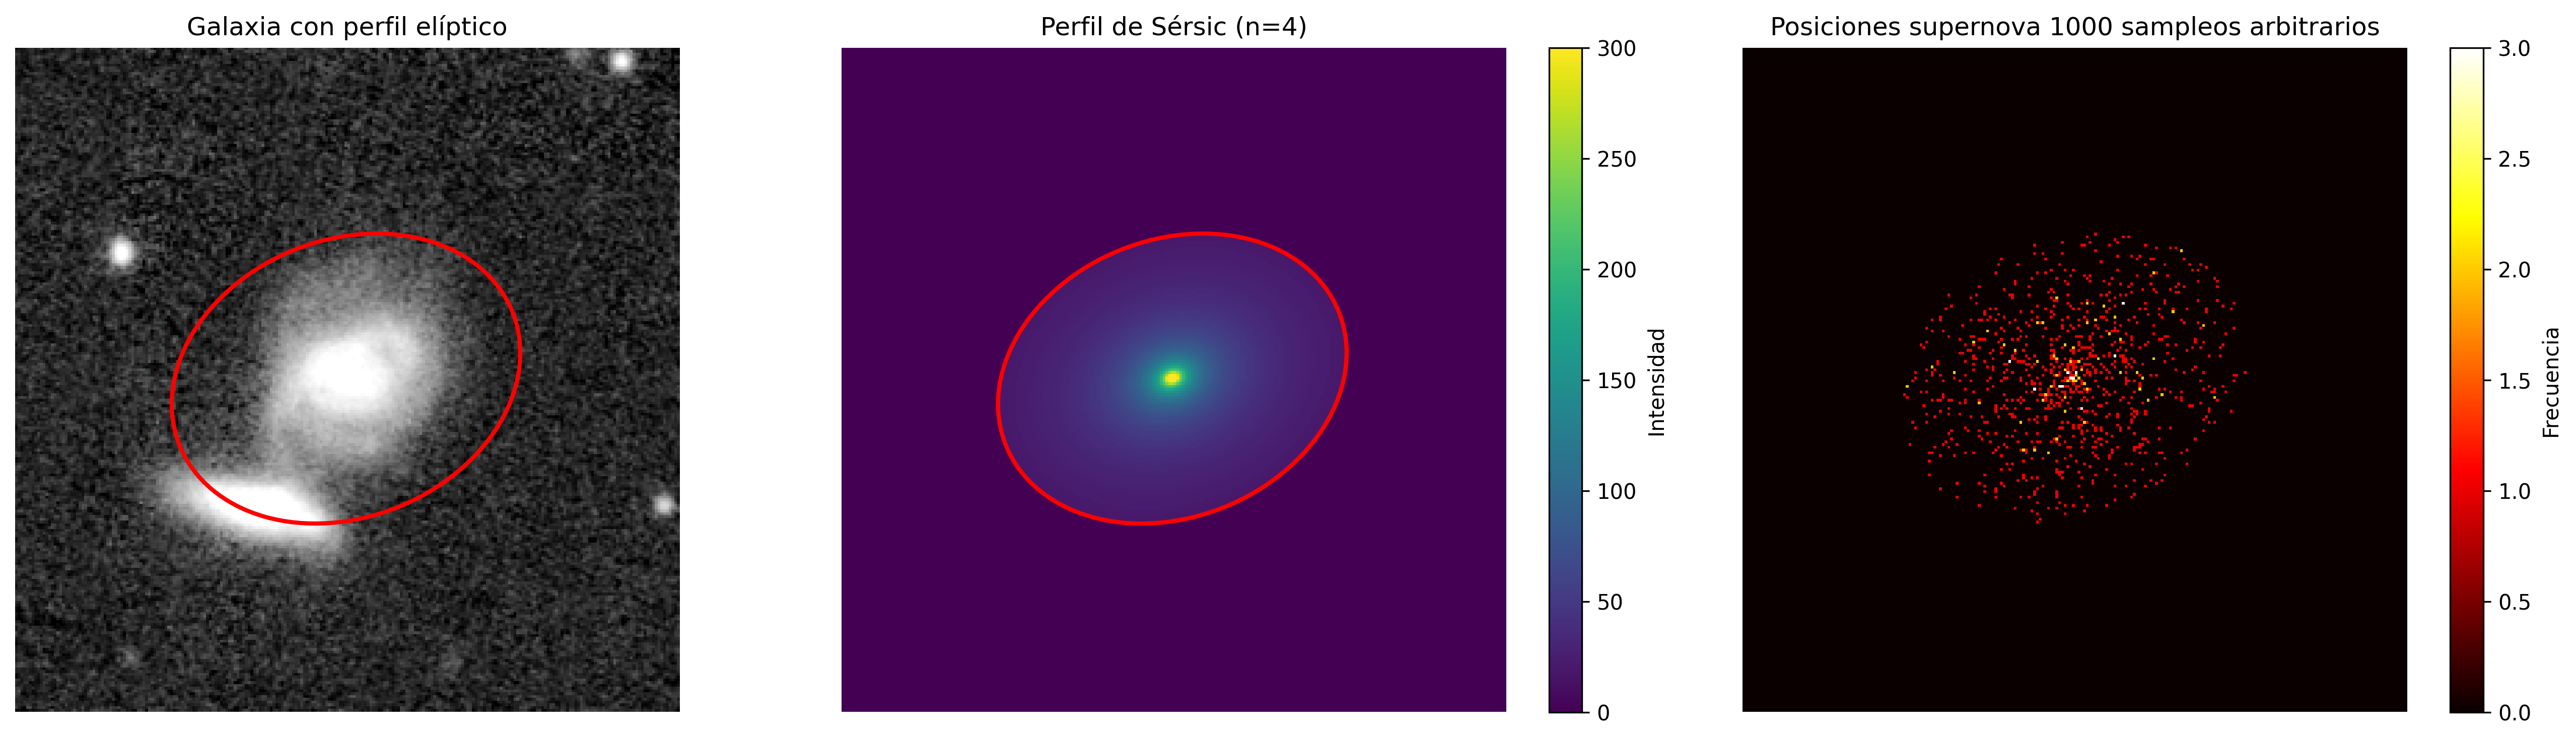

In [12]:
sersic_prof = plot_galaxy_and_sersic(df = df_sersic,
                                     idx = 14) 

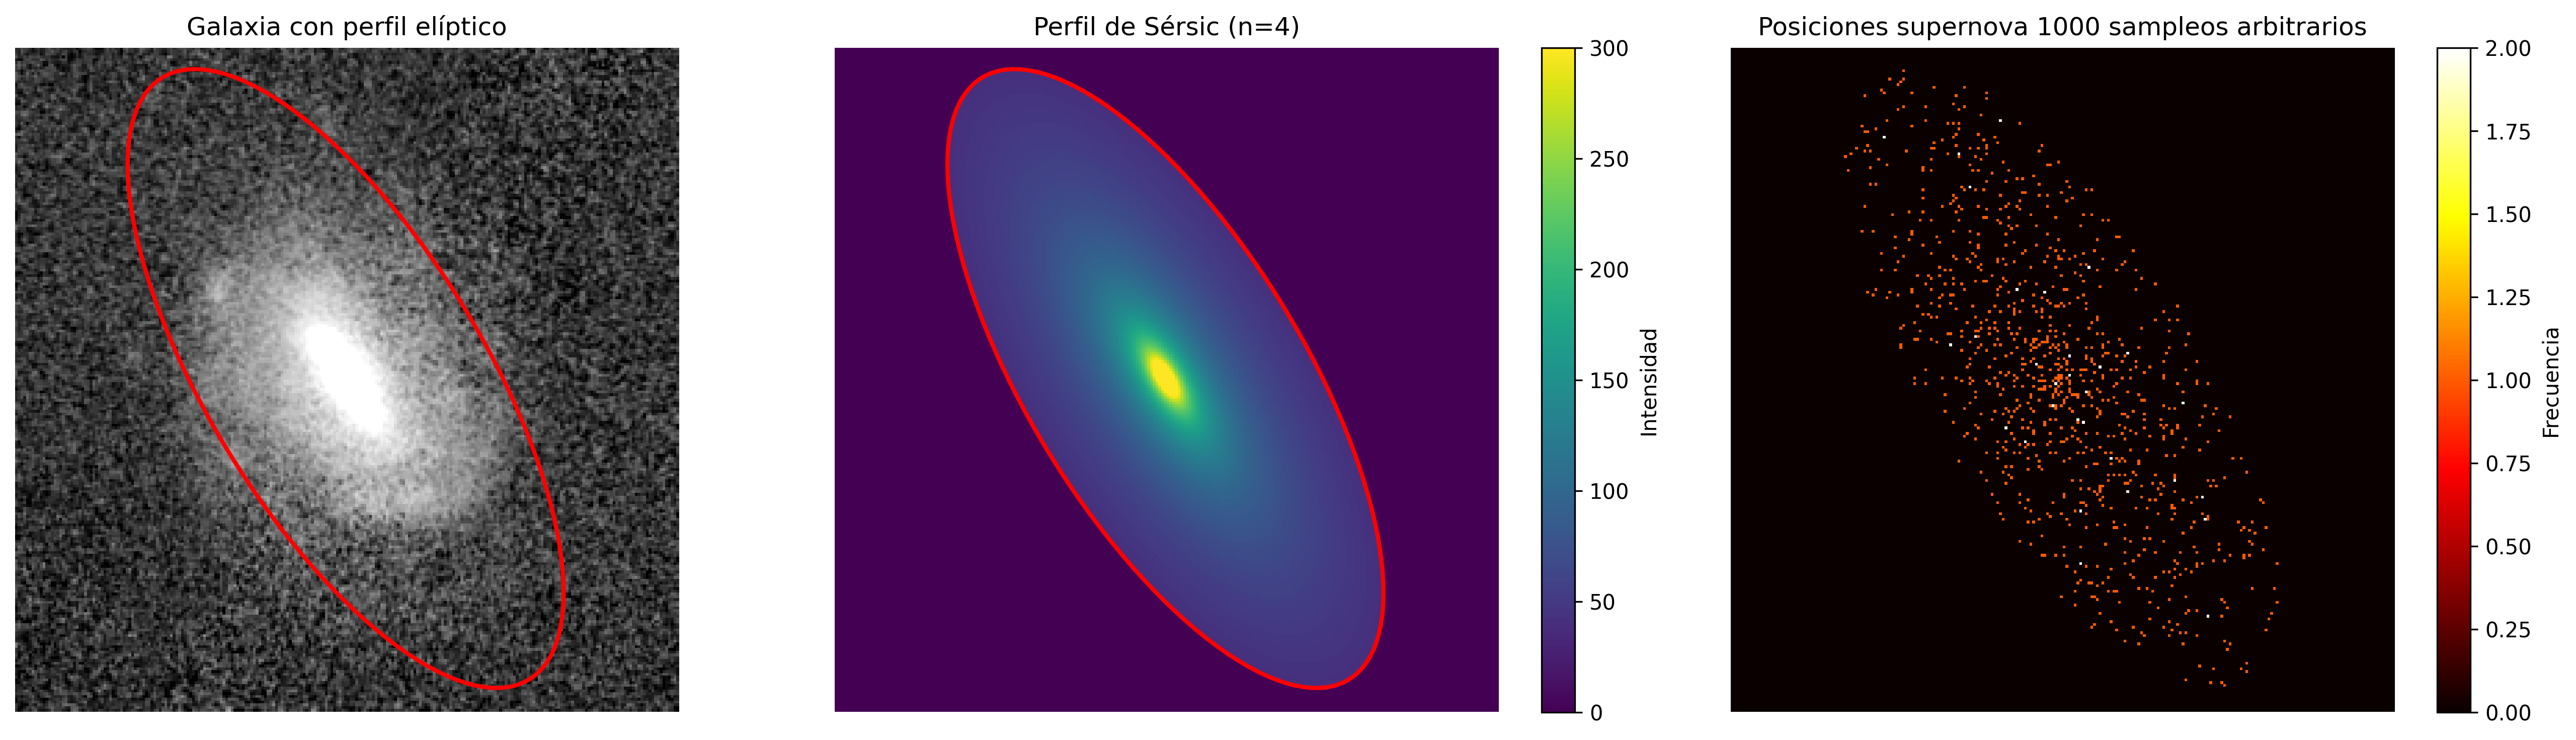

In [13]:
sersic_prof = plot_galaxy_and_sersic(df = df_sersic,
                                     idx = 40) 

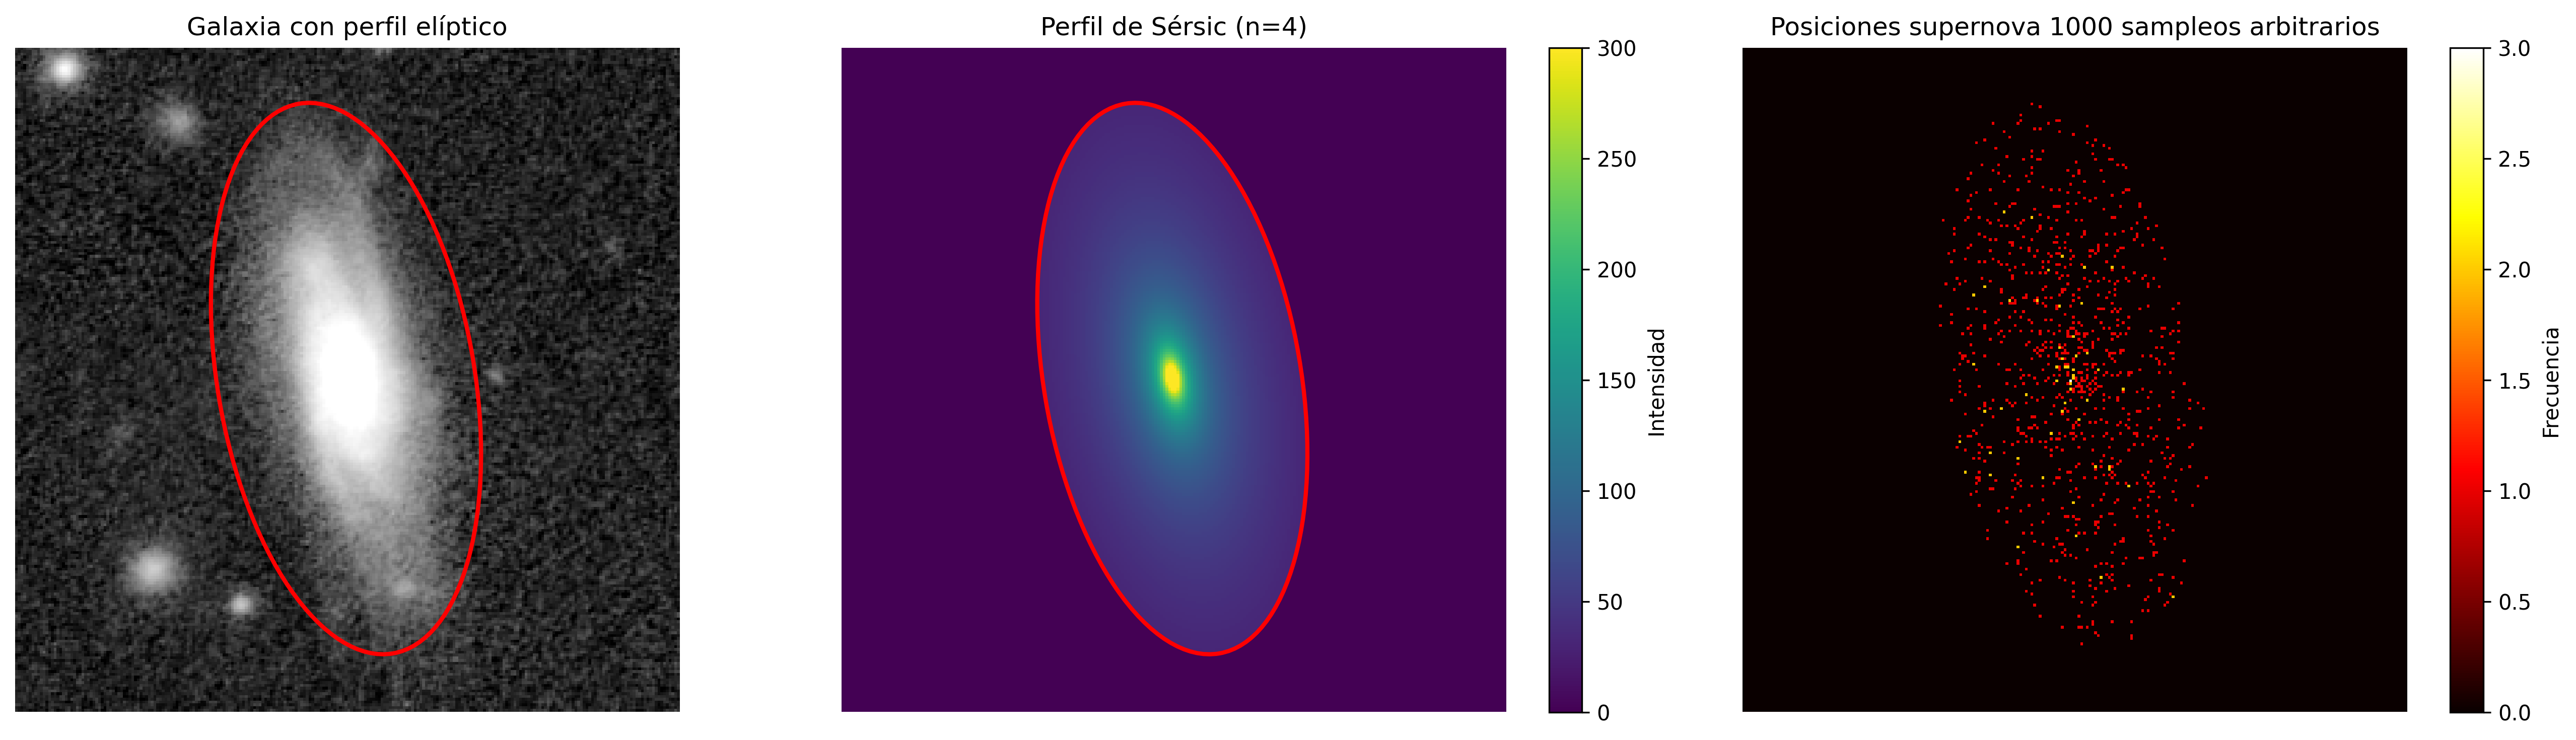

In [14]:
sersic_prof = plot_galaxy_and_sersic(df = df_sersic,
                                     idx = 25) 

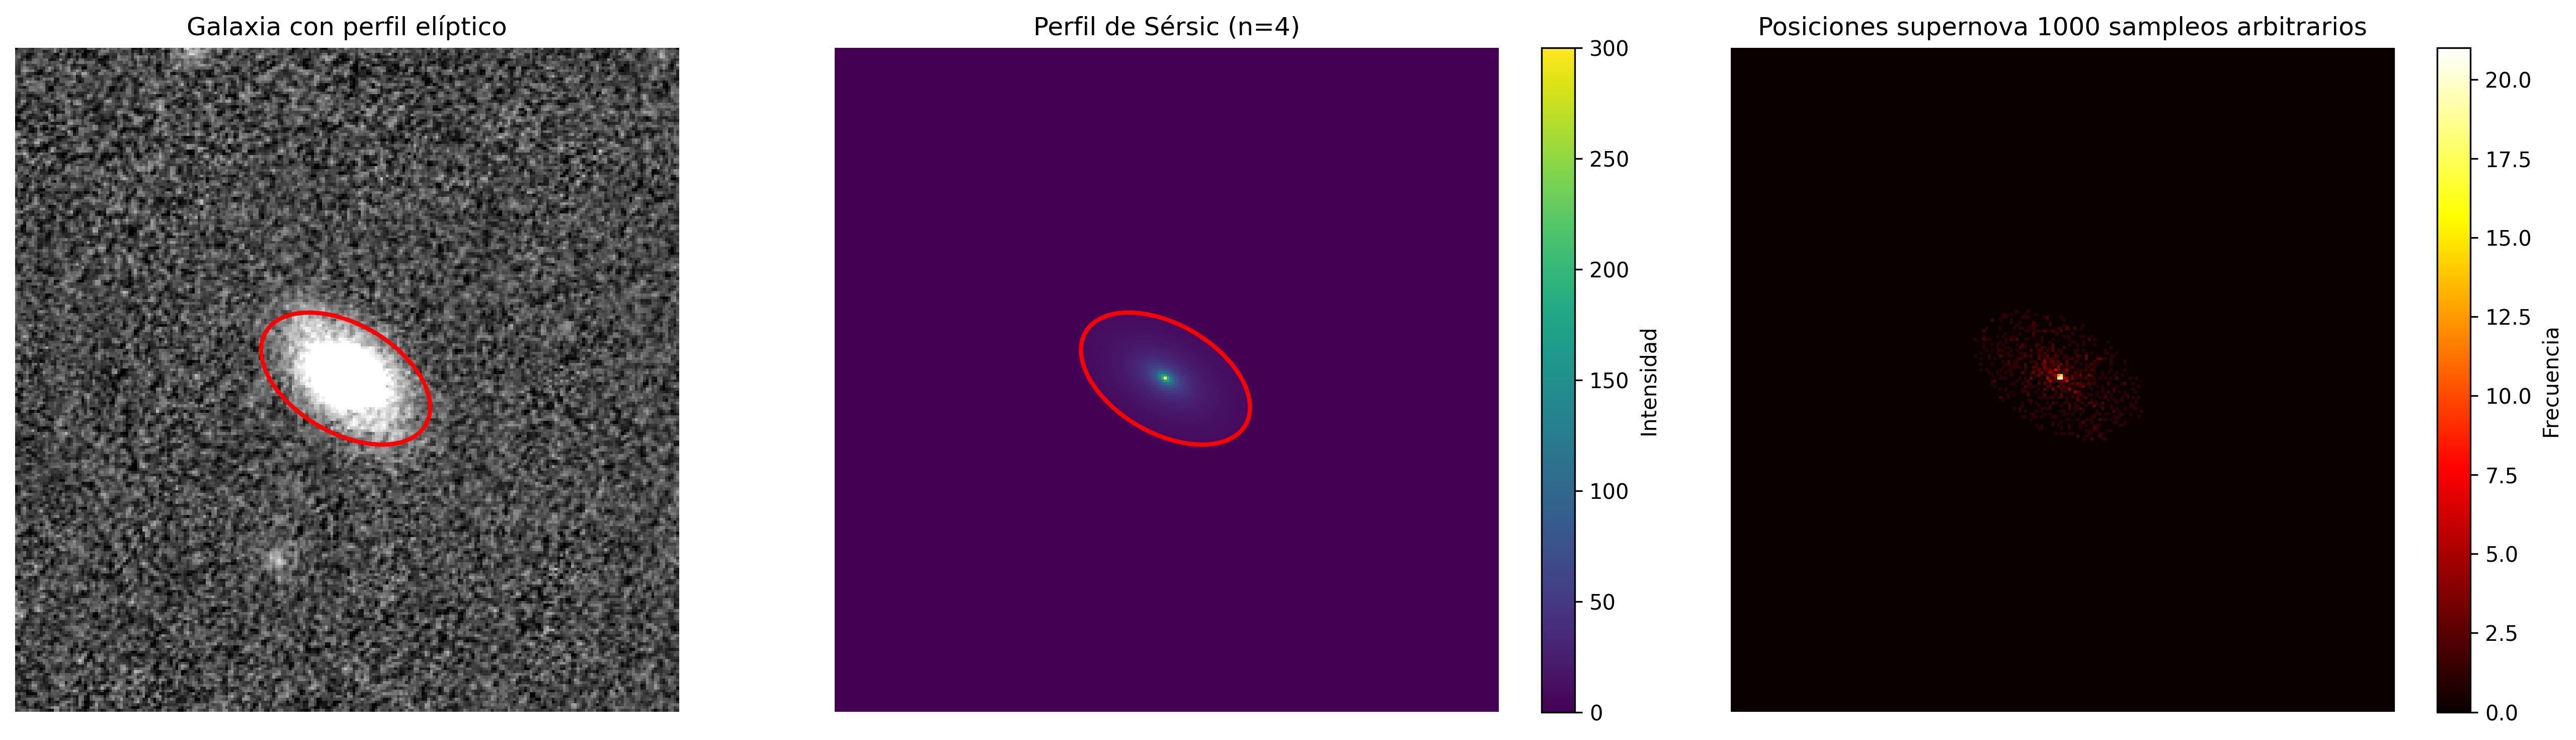

In [15]:
sersic_prof = plot_galaxy_and_sersic(df = df_sersic,
                                     idx = 1) 